# Importation #

## Les librairies nécessaires ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
from scipy.stats import randint

from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.dummy import DummyRegressor

## Les jeux de données ##

In [2]:
# Importation des dataset
data_df = pd.read_csv('Results' + '/' + '02_KnownIndicatorData.csv')
dataToPredict_df = pd.read_csv('Results' + '/' + '03_UnknownIndicatorData.csv')

# Réarrangement des colonnes pour faciliter la suite
colOrderList = ['OSEBuildingID', 'ZipCode', 'YearBuilt', 'BuildingType', 
                'NumberofBuildings', 'NumberofFloors', 'PrimaryPropertyType', 
                'LargestPropertyUseType', 'SecondLargestPropertyUseType',
                'PropertyGFATotal(m2)', 'PropertyGFAParking(m2)', 'SecondLargestPropertyUseTypeGFA(m2)',
                'ENERGYSTARScore', 'SiteEnergyUseWN(GJ)', 'GHGEmissions(MetricTonsCO2e)']

data_df = data_df[colOrderList]
dataToPredict_df = dataToPredict_df[colOrderList[0:-2]]

### Distribution et informations sur les indicateurs recherchés ###

Pour l énergie
Minimum : 4.444E+00, Maximum :1.160E+01, Mediane : 7.944E+00, Moyenne : 8.057E+00
Pour les GES
Minimum : -3.930E-01, Maximum :8.095E+00, Mediane : 3.867E+00, Moyenne : 3.886E+00


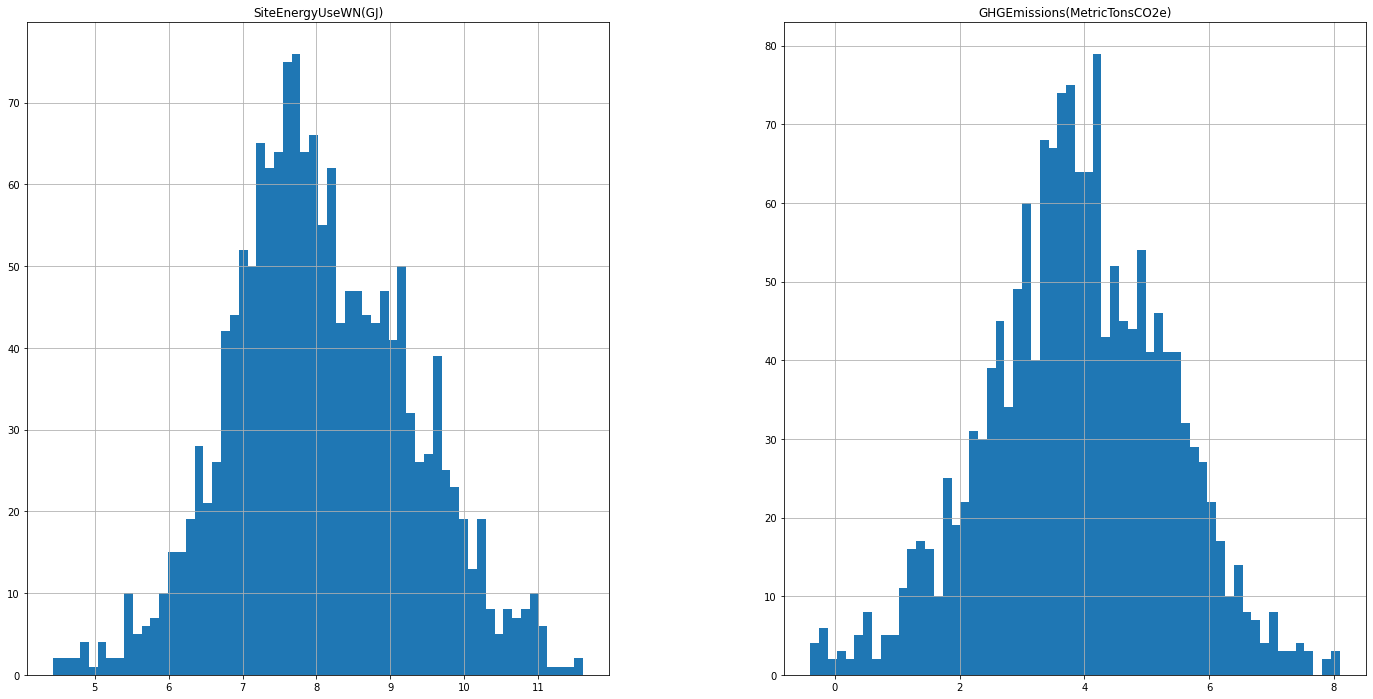

In [3]:
indicatorsCol = ['SiteEnergyUseWN(GJ)', 'GHGEmissions(MetricTonsCO2e)']
data_df[indicatorsCol].hist(figsize = (24,12), bins = 60)
print('Pour l énergie\nMinimum : {:.3E}, Maximum :{:.3E}, Mediane : {:.3E}, Moyenne : {:.3E}'
      .format(data_df[indicatorsCol].min()[0], data_df[indicatorsCol].max()[0], 
              data_df[indicatorsCol].median()[0], data_df[indicatorsCol].mean()[0]))
print('Pour les GES\nMinimum : {:.3E}, Maximum :{:.3E}, Mediane : {:.3E}, Moyenne : {:.3E}'
      .format(data_df[indicatorsCol].min()[1], data_df[indicatorsCol].max()[1], 
              data_df[indicatorsCol].median()[1], data_df[indicatorsCol].mean()[1]))

# Modélisations #

## Préparation des données ##

In [4]:
# Informations sur le jeu de donnees
print('Taille du jeu de donnees : {}\n\nNoms des colonnes\n{}'
      .format(np.shape(data_df),[k for l,k in enumerate(data_df.columns)]))

Taille du jeu de donnees : (1600, 15)

Noms des colonnes
['OSEBuildingID', 'ZipCode', 'YearBuilt', 'BuildingType', 'NumberofBuildings', 'NumberofFloors', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'PropertyGFATotal(m2)', 'PropertyGFAParking(m2)', 'SecondLargestPropertyUseTypeGFA(m2)', 'ENERGYSTARScore', 'SiteEnergyUseWN(GJ)', 'GHGEmissions(MetricTonsCO2e)']


## Initialisation les variables pour la suite ##

In [5]:
X_ESS = data_df.iloc[:,0:-2]# avec ENERGYSTARScore
X = data_df.iloc[:,0:-3]# Sans ENERGYSTARScore
y = data_df.iloc[:,-2:]
y_energy = data_df.iloc[:,-2]
y_GES = data_df.iloc[:,-1] 

categorical_columns = ['OSEBuildingID', 'ZipCode', 'YearBuilt', 'BuildingType', 
                      'NumberofBuildings', 'NumberofFloors', 'PrimaryPropertyType', 
                      'LargestPropertyUseType', 'SecondLargestPropertyUseType']
numerical_columns = ['PropertyGFATotal(m2)', 'PropertyGFAParking(m2)',  
                    'SecondLargestPropertyUseTypeGFA(m2)']
numerical_columns_ESS = ['PropertyGFATotal(m2)', 'PropertyGFAParking(m2)',  
                    'SecondLargestPropertyUseTypeGFA(m2)', 'ENERGYSTARScore']

## Séparation en sous ensembles train et test ##

In [6]:
# Pour les deux indicateurs ensemble
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

X_ESS_train, X_ESS_test, y_ESS_train, y_ESS_test = train_test_split(
    X_ESS, y, random_state=42)

# Pour la consommation d'énergie uniquement
X_train_energy, X_test_energy, y_train_energy, y_test_energy = train_test_split(
    X, y_energy, random_state=42)

X_ESS_train_energy, X_ESS_test_energy, y_ESS_train_energy, y_ESS_test_energy = train_test_split(
    X_ESS, y_energy, random_state=42)

# Pour l'émission de GES uniquement
X_train_GES, X_test_GES, y_train_GES, y_test_GES = train_test_split(
    X, y_GES, random_state=42)

X_ESS_train_GES, X_ESS_test_GES, y_ESS_train_GES, y_ESS_test_GES = train_test_split(
    X_ESS, y_GES, random_state=42)

## Pré-traitement ##

In [7]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
    
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

preprocessingESS = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns_ESS)])

## Modélisation via une Ridge Regression ##

On commence avec une modélisation relativement simple pour voir les premiers résultats.

### On initialise la méthode pour la modèle choisi ###

In [8]:
methodRidge = KernelRidge(kernel = 'linear')

model = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', methodRidge)
])

modelESS = Pipeline([
    ('preprocess', preprocessingESS),
    ('regressor', methodRidge)
])

### Premier test avec l'ENERGYSTARScore ###

In [9]:
# Construction du modele
start_time = timeit.default_timer()
modelESS.fit(X_ESS_train, y_ESS_train)

# Etude de performance sans optimisations
pred = modelESS.predict(X_ESS_test)
elapsed = timeit.default_timer() - start_time

ESSTrainAccuracy =  modelESS.score(X_ESS_train, y_ESS_train)
ESSTestAccuracy = modelESS.score(X_ESS_test, y_ESS_test)
ESSrmse = np.sqrt(mean_squared_error(y_test, modelESS.predict(X_ESS_test)))
ESSTime = elapsed

print("Trained Data ESS train accuracy: %0.3f" % ESSTrainAccuracy)
print("Trained Data ESS test accuracy: %0.3f" % ESSTestAccuracy)
print("The rooot mean squared error (RMSE) on ESS test set: {:.3f}".format(ESSrmse))
print("Elpased Time ESS {:.2f}s".format(ESSTime))

Trained Data ESS train accuracy: 0.933
Trained Data ESS test accuracy: 0.569
The rooot mean squared error (RMSE) on ESS test set: 0.928
Elpased Time ESS 0.13s


### Deuxième test sans l'ENERGYSTARSCore ###

In [10]:
# Construction du modele
start_time = timeit.default_timer()
model.fit(X_train, y_train)

# Etude de performance sans optimisations
pred = model.predict(X_test)
elapsed = timeit.default_timer() - start_time

baseTrainAccuracy =  model.score(X_train, y_train)
baseTestAccuracy = model.score(X_test, y_test)
basermse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
baseTime = elapsed

print("Trained Data Vanilla train accuracy: %0.3f" % baseTrainAccuracy)
print("Trained Data Vanilla test accuracy: %0.3f" % baseTestAccuracy)
print("The root mean squared error (RMSE) on Vanilla test set: {:.3f}".format(basermse))
print("Elpased Time Vanilla {:.2f}s".format(baseTime))

Trained Data Vanilla train accuracy: 0.924
Trained Data Vanilla test accuracy: 0.514
The root mean squared error (RMSE) on Vanilla test set: 0.982
Elpased Time Vanilla 0.14s


### Etude de l'importance des variables dans la décision du modèle ###

En connaissant l'importance portée pour chaque variable, on peut définir celles qui sont le plus importantes pour le modèle et donc restreindre le nombre de variable pour gagner du temps de calcul.

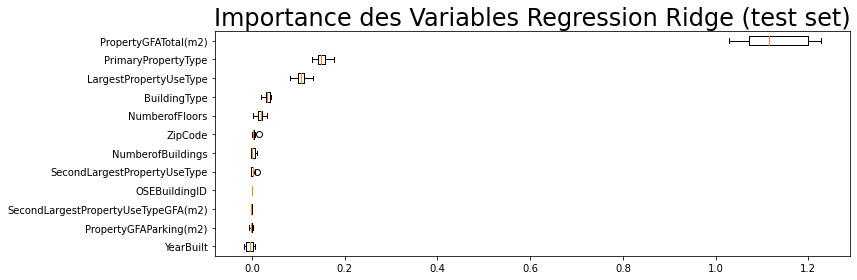

In [11]:
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=0, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (12,4))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Importance des Variables Regression Ridge (test set)", fontsize = 24)
fig.tight_layout()
plt.savefig('Results' + '/' + 'Images' + '/' + 'Importance des Variables Regression Ridge.png',bbox_inches='tight',pad_inches = 1, dpi= 120)
plt.show()

On va garder les quatre variables les plus importantes et voir à quel point nous gagnons du temps et perdons en précision.

In [12]:
# Selection des variables
X_train_selected = X_train[['PropertyGFATotal(m2)', 'LargestPropertyUseType',
                            'PrimaryPropertyType', 'BuildingType']]

# Test avec les nouvelles variables
categorical_columnsSelected = ['PrimaryPropertyType', 'LargestPropertyUseType', 'BuildingType']
numerical_columnsSelected = ['PropertyGFATotal(m2)']

preprocessingSelected = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columnsSelected),
     ('num', numerical_pipe, numerical_columnsSelected)])
modelSelected = Pipeline([
    ('preprocess', preprocessingSelected),
    ('regressor', methodRidge)
])

# Construction du modele
start_time = timeit.default_timer()
modelSelected.fit(X_train_selected, y_train)

# Etude de performance sans optimisations
pred = modelSelected.predict(X_test[list(X_train_selected.columns)])
elapsed = timeit.default_timer() - start_time

selectedTrainAccuracy =  modelSelected.score(X_train_selected, y_train)
selectedTestAccuracy = modelSelected.score(X_test[list(X_train_selected.columns)], y_test)
selectedrmse = np.sqrt(mean_squared_error(y_test, modelSelected.predict(X_test[list(X_train_selected.columns)])))
selectedTime = elapsed

print("Selected Trained Data train accuracy: %0.3f" % selectedTrainAccuracy)
print("Selected Trained Data test accuracy: %0.3f" % selectedTestAccuracy)
print("The root mean squared error (RMSE) on selected test set: {:.3f}".format(selectedrmse))
print("Elpased Time Selected {:.2f}s".format(selectedTime))

Selected Trained Data train accuracy: 0.631
Selected Trained Data test accuracy: 0.572
The root mean squared error (RMSE) on selected test set: 0.924
Elpased Time Selected 0.10s


### Choix des hyperparamètres ###

On va maintenant établir les meilleurs hyperparamètres à choisir grâce à une validation croisée pour chercher à optimiser notre modèle.

In [13]:
# Force de régularisation des variables
alphas = np.logspace(-5, 5, 10000)
parametersGrid = {'alpha' : alphas}

# Preparation du test des hyperparametres
method_random = RandomizedSearchCV(estimator = methodRidge,
                                  param_distributions = parametersGrid, n_iter = 1000,
                                  cv = 5, verbose = 2, random_state=0,
                                  n_jobs = -1)
model_random = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', method_random)
])

# Optimisation des hyperparametres
model_random.fit(X_train, y_train)

print('\n\nLes meilleurs hyperparametres trouves sont : {} \navec un score de {:.2f}'.format(method_random.best_params_, method_random.best_score_))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 1978 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 2868 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 3922 tasks      | elapsed:  1.2min




Les meilleurs hyperparametres trouves sont : {'alpha': 0.7054802310718645} 
avec un score de 0.52


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.6min finished


On fait maintenant un nouveau test avec les hyperparamètres optimisés.

In [14]:
optimizedMethod = KernelRidge(kernel = 'linear', 
                              alpha = method_random.best_params_['alpha'])

optimizedModel = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', optimizedMethod)
])

# Construction du modele
start_time = timeit.default_timer()
optimizedModel.fit(X_train, y_train)

# Etude de performance avec optimisations

pred = optimizedModel.predict(X_test)
elapsed = timeit.default_timer() - start_time

optimizedTrainAccuracy =  optimizedModel.score(X_train, y_train)
optimizedTestAccuracy = optimizedModel.score(X_test, y_test)
optimizedrmse = np.sqrt(mean_squared_error(y_test, optimizedModel.predict(X_test)))
optimizedTime = elapsed

print("Optimized Trained Data train accuracy: %0.3f\n" % (optimizedTrainAccuracy))
print("Optimized Trained Data test accuracy: %0.3f\n" % (optimizedTestAccuracy))
print("Optimized Trained Data test RMSE: %0.3f\n" % (optimizedrmse))
print("Elapsed Time Optimized {:.2f}s\n".format(optimizedTime))

Optimized Trained Data train accuracy: 0.949

Optimized Trained Data test accuracy: 0.514

Optimized Trained Data test RMSE: 0.982

Elapsed Time Optimized 0.13s



### Tableau Récapitulatif ###

On prends maintenant tous les résultats pour pouvoir les comparer facilement et choisir la meilleure méthode pour ce modèle.

In [15]:
resultatsRidge_df = pd.DataFrame()

resultatsRidge_df['Trained Data'] = ['Vanilla','Avec ENERGYSTARScore','Moins de Variables','Hyperparametres Optimisés']
resultatsRidge_df['Train Precision'] = [baseTrainAccuracy, ESSTrainAccuracy, selectedTrainAccuracy, optimizedTrainAccuracy]
resultatsRidge_df['Test Precision'] = [baseTestAccuracy, ESSTestAccuracy, selectedTestAccuracy, optimizedTestAccuracy]
resultatsRidge_df['RMSE'] = [basermse, ESSrmse, selectedrmse, optimizedrmse]
resultatsRidge_df['Time'] = [baseTime, ESSTime, selectedTime, optimizedTime]
resultatsRidge_df

,Trained Data,Train Precision,Test Precision,RMSE,Time
0,Vanilla,0.924380,0.513767,0.981673,0.140868
1,Avec ENERGYSTARScore,0.932660,0.568779,0.927708,0.134164
2,Moins de Variables,0.630628,0.571942,0.924087,0.102385
3,Hyperparametres Optimisés,0.949026,0.514063,0.981908,0.127492


### Graphique Correspondant ###

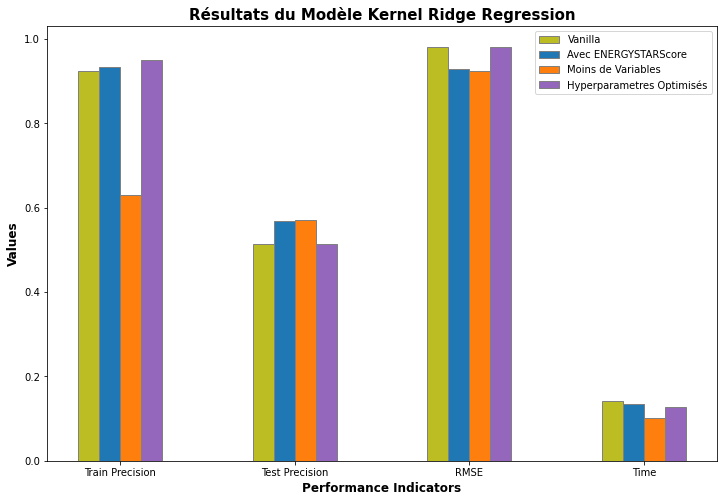

In [16]:
# set width of bar
barWidth = 0.12
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(4)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, list(resultatsRidge_df.iloc[0,1:5]), color ='tab:olive', width = barWidth,
        edgecolor ='grey', label ='Vanilla')
plt.bar(br2, list(resultatsRidge_df.iloc[1,1:5]), color ='tab:blue', width = barWidth,
        edgecolor ='grey', label ='Avec ENERGYSTARScore')
plt.bar(br3, list(resultatsRidge_df.iloc[2,1:5]), color ='tab:orange', width = barWidth,
        edgecolor ='grey', label ='Moins de Variables')
plt.bar(br4, list(resultatsRidge_df.iloc[3,1:5]), color ='tab:purple', width = barWidth,
        edgecolor ='grey', label ='Hyperparametres Optimisés')
 
# Adding Xticks
plt.xlabel('Performance Indicators', fontweight ='bold', fontsize = 12)
plt.ylabel('Values', fontweight ='bold', fontsize = 12)
plt.xticks([r + 1.5 * barWidth for r in range(4)],
        ['Train Precision', 'Test Precision', 'RMSE', 'Time'])
plt.title('Résultats du Modèle Kernel Ridge Regression', fontweight ='bold', fontsize = 15)
plt.legend()
plt.savefig('Results' + '/' + 'Images' + '/' + 'Résultats du Modèle Kernel Ridge Regression.png',bbox_inches='tight',pad_inches = 1, dpi= 120)
plt.show()

D'après les résultats, nous pouvons en déduire que la méthode la plus adaptée et d'utiliser l'ENERGYSTARScore avec les hyperparamètres optimisés et moins de variables.

Nous allons donc nous servir de cette méthode pour prévoir nos indicateurs avec notre modèle.

### Prediction ###

In [17]:
start_time = timeit.default_timer()

# Construction du modele
chosen_numerical_columns = numerical_columnsSelected
chosen_numerical_columns.append('ENERGYSTARScore')

chosenPreprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columnsSelected),
     ('num', numerical_pipe, chosen_numerical_columns)])
chosenModel = Pipeline([
    ('preprocess', chosenPreprocessing),
    ('regressor', optimizedMethod)
])
chosenModel.fit(X_ESS_train, y_ESS_train)

# Predictions
pred = chosenModel.predict(dataToPredict_df)
elapsed = timeit.default_timer() - start_time
predTime = elapsed

# Stockage des performances
RidgeChosenTrainAccuracy =  chosenModel.score(X_ESS_train, y_ESS_train)
RidgeChosenTestAccuracy = chosenModel.score(X_ESS_test, y_ESS_test)
RidgeChosenrmse = np.sqrt(mean_squared_error(y_ESS_test, chosenModel.predict(X_ESS_test)))
RidgeChosenTime = elapsed

print("Temps écoulé {:.2f}s".format(predTime))
print(pred)

Temps écoulé 0.09s
[[7.82867618 3.96117457]
 [8.48576526 3.88825188]
 [8.14446787 3.68938573]
 [7.4560166  3.58820439]
 [6.45255916 2.74873828]
 [7.16016979 3.43228787]
 [7.35877167 3.49087841]
 [7.5595438  3.69181787]
 [8.59141521 4.7245493 ]
 [7.61755585 3.74987827]
 [8.31400883 4.6597662 ]
 [7.08679579 2.79688325]
 [8.21954785 4.17424603]
 [9.51278516 5.46856119]]


On implémente enfin les résultats dans notre jeu de données, puis on l'enregistre.

In [18]:
# Implantation des predictions dans le jeu de donnees : 
for i in range(len(pred)):
    dataToPredict_df.loc[i,'SiteEnergyUseWN(GJ)'] = np.exp(pred[i][0])
    dataToPredict_df.loc[i,'TotalGHGEmissions(MetricTonsCO2e)'] = np.exp(pred[i][1])

# Enregistrement
dataToPredict_df.to_csv('Results'+'/'+'04_KernelRidgePredictedIndicatorData.csv', index = False)

dataToPredict_df

,OSEBuildingID,ZipCode,YearBuilt,BuildingType,NumberofBuildings,NumberofFloors,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,PropertyGFATotal(m2),PropertyGFAParking(m2),SecondLargestPropertyUseTypeGFA(m2),ENERGYSTARScore,SiteEnergyUseWN(GJ),TotalGHGEmissions(MetricTonsCO2e)
0,87.0,98146.0,1948.0,SPS-District K-12,1.0,2.0,K-12 School,K-12 School,NaN,8.508468,NaN,NaN,NaN,2511.602268,52.518977
1,757.0,98121.0,1979.0,NonResidential,1.0,7.0,Large Office,Office,Retail Store,9.407845,8.999302,6.915998,93.5,4845.303974,48.825459
2,773.0,98104.0,1924.0,NonResidential,NaN,4.0,Small- and Mid-Sized Office,NaN,NaN,8.677069,NaN,NaN,NaN,3444.272087,40.020256
3,19694.0,98122.0,1925.0,SPS-District K-12,1.0,2.0,K-12 School,K-12 School,NaN,8.151273,NaN,NaN,NaN,1730.242065,36.169072
4,20130.0,98115.0,1910.0,NonResidential,1.0,2.0,Worship Facility,Worship Facility,NaN,7.706731,NaN,NaN,89.5,634.323553,15.622908
5,20324.0,98115.0,2000.0,NonResidential,1.0,2.0,Worship Facility,Worship Facility,NaN,7.977918,NaN,NaN,55.0,1287.129457,30.947365
6,21570.0,98125.0,1950.0,SPS-District K-12,1.0,1.0,K-12 School,K-12 School,NaN,8.058064,NaN,NaN,NaN,1569.907012,32.814760
7,21578.0,98116.0,1949.0,SPS-District K-12,1.0,1.0,K-12 School,K-12 School,NaN,8.250504,NaN,NaN,NaN,1918.969873,40.117709
8,24408.0,98103.0,1953.0,SPS-District K-12,1.0,1.0,K-12 School,K-12 School,NaN,9.239554,NaN,NaN,NaN,5385.229498,112.679702
9,25361.0,98115.0,1961.0,SPS-District K-12,1.0,1.0,K-12 School,K-12 School,NaN,8.306109,NaN,NaN,NaN,2033.585654,42.515906


## Modélisation via une Random Forest ##

On essaye maintenant avec une modélisation un peu plus poussée pour voir si on peut avoir de meilleurs résultats.

### On initialise la méthode pour la modèle choisi ###

In [19]:
methodForest = RandomForestRegressor(max_features = None, random_state=0, n_jobs = -1)

model = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', methodForest)
])

modelESS = Pipeline([
    ('preprocess', preprocessingESS),
    ('regressor', methodForest)
])

### Premier test avec l'ENERGYSTARScore ###

In [20]:
# Construction du modele
start_time = timeit.default_timer()
modelESS.fit(X_ESS_train, y_ESS_train)

# Etude de performance sans optimisations
pred = modelESS.predict(X_ESS_test)
elapsed = timeit.default_timer() - start_time

ESSTrainAccuracy =  modelESS.score(X_ESS_train, y_ESS_train)
ESSTestAccuracy = modelESS.score(X_ESS_test, y_ESS_test)
ESSrmse = np.sqrt(mean_squared_error(y_test, modelESS.predict(X_ESS_test)))
ESSTime = elapsed

print("Trained Data ESS train accuracy: %0.3f" % ESSTrainAccuracy)
print("Trained Data ESS test accuracy: %0.3f" % ESSTestAccuracy)
print("The root mean squared error (MSE) on ESS test set: {:.3f}".format(ESSrmse))
print("Elpased Time ESS {:.2f}s\n\n".format(ESSTime))

Trained Data ESS train accuracy: 0.944
Trained Data ESS test accuracy: 0.572
The root mean squared error (MSE) on ESS test set: 0.928
Elpased Time ESS 1.34s




### Deuxième test sans l'ENERGYSTARScore ###

In [21]:
# Construction du modele
start_time = timeit.default_timer()
model.fit(X_train, y_train)

# Etude de performance sans optimisations
pred = model.predict(X_test)
elapsed = timeit.default_timer() - start_time

baseTrainAccuracy =  model.score(X_train, y_train)
baseTestAccuracy = model.score(X_test, y_test)
basermse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
baseTime = elapsed

print("Trained Data Vanilla train accuracy: %0.3f" % baseTrainAccuracy)
print("Trained Data Vanilla test accuracy: %0.3f" % baseTestAccuracy)
print("The root mean squared error (RMSE) on Vanilla test set: {:.3f}".format(basermse))
print("Elpased Time Vanilla {:.2f}s".format(baseTime))

Trained Data Vanilla train accuracy: 0.938
Trained Data Vanilla test accuracy: 0.527
The root mean squared error (RMSE) on Vanilla test set: 0.971
Elpased Time Vanilla 1.27s


### Etude de l'importance des variables dans la décision du modèle ###

En connaissant l'importance portée pour chaque variable, on peut définir celles qui sont le plus importantes pour le modèle et donc restreindre le nombre de variable pour gagner du temps de calcul.

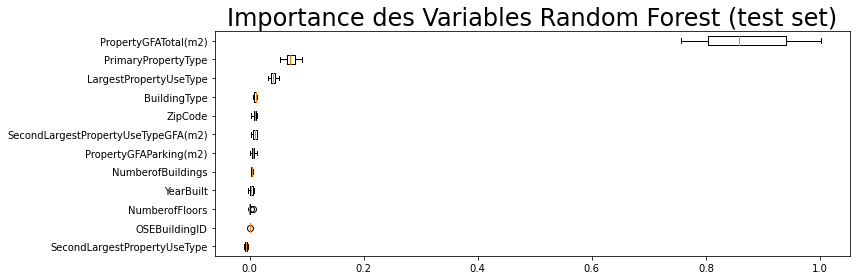

In [22]:
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=0, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (12,4))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Importance des Variables Random Forest (test set)", fontsize = 24)
fig.tight_layout()
plt.savefig('Results' + '/' + 'Images' + '/' + 'Importance des Variables Random Forest.png',bbox_inches='tight',pad_inches = 1, dpi= 120)
plt.show()

On va garder les trois variables les plus importantes et voir à quel point nous gagnons du temps et perdons en précision.

In [23]:
# Selection des variables
X_train_selected = X_train[['PropertyGFATotal(m2)', 'PrimaryPropertyType',
                            'LargestPropertyUseType']]

# Test avec les nouvelles variables
categorical_columnsSelected = ['PrimaryPropertyType', 'LargestPropertyUseType']
numerical_columnsSelected = ['PropertyGFATotal(m2)']

preprocessingSelected = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columnsSelected),
     ('num', numerical_pipe, numerical_columnsSelected)])
modelSelected = Pipeline([
    ('preprocess', preprocessingSelected),
    ('regressor', methodForest)
])

# Construction du modele
start_time = timeit.default_timer()
modelSelected.fit(X_train_selected, y_train)

# Etude de performance sans optimisations
pred = modelSelected.predict(X_test[list(X_train_selected.columns)])
elapsed = timeit.default_timer() - start_time

selectedTrainAccuracy =  modelSelected.score(X_train_selected, y_train)
selectedTestAccuracy = modelSelected.score(X_test[list(X_train_selected.columns)], y_test)
selectedrmse = np.sqrt(mean_squared_error(y_test, modelSelected.predict(X_test[list(X_train_selected.columns)])))
selectedTime = elapsed

print("Selected Trained Data train accuracy: %0.3f" % selectedTrainAccuracy)
print("Selected Trained Data test accuracy: %0.3f" % selectedTestAccuracy)
print("The root mean squared error (RMSE) on selected test set: {:.3f}".format(selectedrmse))
print("Elapsed Time Selected {:.2f}s".format(selectedTime))

Selected Trained Data train accuracy: 0.928
Selected Trained Data test accuracy: 0.441
The root mean squared error (RMSE) on selected test set: 1.057
Elapsed Time Selected 0.37s


### Choix des hyperparamètres ###

On va maintenant établir les meilleurs hyperparamètres à choisir grâce à une validation croisée pour chercher à optimiser notre modèle.

Dans un premier temps, on établit les paramètres sur lesquels tester la méthode.

In [24]:
# Optimisation des hyperparamètres
# Nombre d'arbres dans la forêt
n_estimators = randint(1, 600)

# Taille maximum des arbres
max_depth = [None]
max_depth.append(randint(1, 60))

# Nombre minimum d'échantillon requis pour créer un embranchement
min_samples_split = randint(2, 60)

# Nombre minimum d'échantillon à chaque feuille
min_samples_leaf = randint(1, 60)

# Dictionnaire pour l'evaluation des parametres
grid_parameters = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

Recherche à proprement parler des hyperparamètres.

In [25]:
# Preparation du test des hyperparametres
method_random = RandomizedSearchCV(estimator = methodForest,
                                  param_distributions = grid_parameters, n_iter = 600,
                                  cv = 5, verbose = 6, random_state=0, n_jobs = -1)
model_random = Pipeline([
    ('preprocess', preprocessingESS),
    ('regressor', method_random)
])

# Optimisation des hyperparametres
model_random.fit(X_ESS_train, y_ESS_train)


print('\n\nLes meilleurs hyperparametres trouves sont : {} \navec un score de {:.2f}'.format(method_random.best_params_, method_random.best_score_))

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1505 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 2105 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 2837 tasks      | elap



Les meilleurs hyperparametres trouves sont : {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 267} 
avec un score de 0.61


On fait maintenant un nouveau test avec les hyperparamètres optimisés.

In [26]:
optimizedMethod = RandomForestRegressor(n_estimators = method_random.best_params_['n_estimators'], 
                               min_samples_split = method_random.best_params_['min_samples_split'], 
                               min_samples_leaf = method_random.best_params_['min_samples_leaf'], 
                               max_depth = method_random.best_params_['max_depth'], 
                               max_features = None, random_state=0, n_jobs = -1)

optimizedModel = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', optimizedMethod)
])

# Construction du modele
start_time = timeit.default_timer()
optimizedModel.fit(X_train, y_train)

# Etude de performance avec optimisations

pred = optimizedModel.predict(X_test)
elapsed = timeit.default_timer() - start_time

optimizedTrainAccuracy =  optimizedModel.score(X_train, y_train)
optimizedTestAccuracy = optimizedModel.score(X_test, y_test)
optimizedrmse = np.sqrt(mean_squared_error(y_test, optimizedModel.predict(X_test)))
optimizedTime = elapsed

print("Optimized Trained Data train accuracy: %0.3f\n" % (optimizedTrainAccuracy))
print("Optimized Trained Data test accuracy: %0.3f\n" % (optimizedTestAccuracy))
print("Optimized Trained DAta test RMSE: %0.3f\n" % (optimizedrmse))
print("Optimized Elapsed Time {:.2f}s\n".format(optimizedTime))

Optimized Trained Data train accuracy: 0.794

Optimized Trained Data test accuracy: 0.517

Optimized Trained DAta test RMSE: 0.982

Optimized Elapsed Time 1.25s



### Tableau Récapitulatif ###

On prends maintenant tous les résultats pour pouvoir les comparer facilement et choisir la meilleure méthode pour ce modèle.

In [27]:
# Tableau Recap
resultatsForest_df = pd.DataFrame()

resultatsForest_df['Trained Data'] = ['Vanilla','Avec ENERGYSTARScore','Moins de Variables','Hyperparametres Optimisés']
resultatsForest_df['Train Precision'] = [baseTrainAccuracy, ESSTrainAccuracy, selectedTrainAccuracy, optimizedTrainAccuracy]
resultatsForest_df['Test Precision'] = [baseTestAccuracy, ESSTestAccuracy, selectedTestAccuracy, optimizedTestAccuracy]
resultatsForest_df['RMSE'] = [basermse, ESSrmse, selectedrmse, optimizedrmse]
resultatsForest_df['Time'] = [baseTime, ESSTime, selectedTime, optimizedTime]
resultatsForest_df

,Trained Data,Train Precision,Test Precision,RMSE,Time
0,Vanilla,0.938365,0.527356,0.971168,1.273797
1,Avec ENERGYSTARScore,0.944224,0.572100,0.927605,1.343803
2,Moins de Variables,0.927621,0.440726,1.057483,0.365810
3,Hyperparametres Optimisés,0.793675,0.516505,0.982177,1.252381


### Graphique Correspondant ###

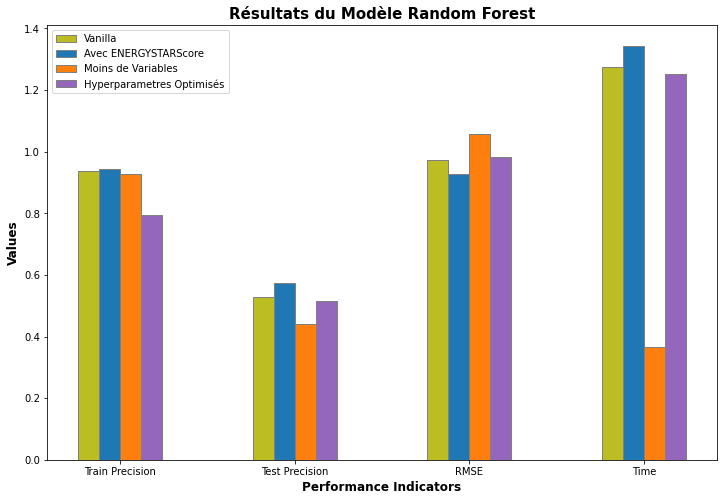

In [28]:
# set width of bar
barWidth = 0.12
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(4)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, list(resultatsForest_df.iloc[0,1:5]), color ='tab:olive', width = barWidth,
        edgecolor ='grey', label ='Vanilla')
plt.bar(br2, list(resultatsForest_df.iloc[1,1:5]), color ='tab:blue', width = barWidth,
        edgecolor ='grey', label ='Avec ENERGYSTARScore')
plt.bar(br3, list(resultatsForest_df.iloc[2,1:5]), color ='tab:orange', width = barWidth,
        edgecolor ='grey', label ='Moins de Variables')
plt.bar(br4, list(resultatsForest_df.iloc[3,1:5]), color ='tab:purple', width = barWidth,
        edgecolor ='grey', label ='Hyperparametres Optimisés')

# Adding Xticks
plt.xlabel('Performance Indicators', fontweight ='bold', fontsize = 12)
plt.ylabel('Values', fontweight ='bold', fontsize = 12)
plt.xticks([r + 1.5 * barWidth for r in range(4)],
        ['Train Precision', 'Test Precision', 'RMSE', 'Time'])

plt.title('Résultats du Modèle Random Forest', fontweight ='bold', fontsize = 15)
plt.legend()
plt.savefig('Results' + '/' + 'Images' + '/' + 'Résultats du Modèle Random Forest.png',bbox_inches='tight',pad_inches = 1, dpi= 120)
plt.show()

D'après les résultats, nous pouvons en déduire que la méthode la plus adaptée et d'utiliser l'ENERGYSTARScore.

Nous allons donc nous servir de cette méthode pour prévoir nos indicateurs avec notre modèle.

### Prediction ###

In [29]:
start_time = timeit.default_timer()

# Construction du modele
chosenModel = Pipeline([
    ('preprocess', preprocessingESS),
    ('regressor', methodForest)
])
chosenModel.fit(X_ESS_train, y_ESS_train)

# Predictions
pred = chosenModel.predict(dataToPredict_df.iloc[:,:-2])
elapsed = timeit.default_timer() - start_time
predTime = elapsed

# Stockage des performances
ForestChosenTrainAccuracy =  chosenModel.score(X_ESS_train, y_ESS_train)
ForestChosenTestAccuracy = chosenModel.score(X_ESS_test, y_ESS_test)
ForestChosenrmse = np.sqrt(mean_squared_error(y_ESS_test, chosenModel.predict(X_ESS_test)))
ForestChosenTime = elapsed

print("Temps écoulé {:.2f}s".format(predTime))
print(pred)

Temps écoulé 1.18s
[[7.53847522 3.53824241]
 [8.63108112 3.95528266]
 [8.06482217 3.56003308]
 [7.67982389 3.97233163]
 [6.68827912 2.78497586]
 [7.65583155 3.88036329]
 [7.55920873 3.83751076]
 [7.5451681  3.82782648]
 [8.78255275 5.24117015]
 [7.54605461 3.78353737]
 [7.93662424 4.07000019]
 [6.84804764 2.61928166]
 [7.94620686 3.99262975]
 [9.30980454 5.44186558]]


On implémente enfin les résultats dans notre jeu de données, puis on l'enregistre.

In [30]:
# Implantation des predictions dans le jeu de donnees : 
for i in range(len(pred)):
    dataToPredict_df.loc[i,'SiteEnergyUseWN(GJ)'] = np.exp(pred[i][0])
    dataToPredict_df.loc[i,'TotalGHGEmissions(MetricTonsCO2e)'] = np.exp(pred[i][1])
    
# Enregistrement
dataToPredict_df.to_csv('Results'+'/'+'05_ForestPredictedIndicatorData.csv', index = False)
dataToPredict_df

,OSEBuildingID,ZipCode,YearBuilt,BuildingType,NumberofBuildings,NumberofFloors,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,PropertyGFATotal(m2),PropertyGFAParking(m2),SecondLargestPropertyUseTypeGFA(m2),ENERGYSTARScore,SiteEnergyUseWN(GJ),TotalGHGEmissions(MetricTonsCO2e)
0,87.0,98146.0,1948.0,SPS-District K-12,1.0,2.0,K-12 School,K-12 School,NaN,8.508468,NaN,NaN,NaN,1878.962838,34.406394
1,757.0,98121.0,1979.0,NonResidential,1.0,7.0,Large Office,Office,Retail Store,9.407845,8.999302,6.915998,93.5,5603.132661,52.210450
2,773.0,98104.0,1924.0,NonResidential,NaN,4.0,Small- and Mid-Sized Office,NaN,NaN,8.677069,NaN,NaN,NaN,3180.590563,35.164360
3,19694.0,98122.0,1925.0,SPS-District K-12,1.0,2.0,K-12 School,K-12 School,NaN,8.151273,NaN,NaN,NaN,2164.238588,53.108215
4,20130.0,98115.0,1910.0,NonResidential,1.0,2.0,Worship Facility,Worship Facility,NaN,7.706731,NaN,NaN,89.5,802.939301,16.199427
5,20324.0,98115.0,2000.0,NonResidential,1.0,2.0,Worship Facility,Worship Facility,NaN,7.977918,NaN,NaN,55.0,2112.931400,48.441810
6,21570.0,98125.0,1950.0,SPS-District K-12,1.0,1.0,K-12 School,K-12 School,NaN,8.058064,NaN,NaN,NaN,1918.326991,46.409806
7,21578.0,98116.0,1949.0,SPS-District K-12,1.0,1.0,K-12 School,K-12 School,NaN,8.250504,NaN,NaN,NaN,1891.580694,45.962529
8,24408.0,98103.0,1953.0,SPS-District K-12,1.0,1.0,K-12 School,K-12 School,NaN,9.239554,NaN,NaN,NaN,6519.498599,188.891004
9,25361.0,98115.0,1961.0,SPS-District K-12,1.0,1.0,K-12 School,K-12 School,NaN,8.306109,NaN,NaN,NaN,1893.258329,43.971310


## Modélisation via un Gradient Boosting ##

On essaye maintenant avec une autre modélisation poussée qui pourrait être plus performante pour voir si on peut avoir de meilleurs résultats.

### On initialise la méthode pour la modèle choisi ###

#### On commence avec les GES ####

In [31]:
methodGB = GradientBoostingRegressor(max_features = None, random_state=0)

modelGES = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', methodGB)
])

modelESSGES = Pipeline([
    ('preprocess', preprocessingESS),
    ('regressor', methodGB)
])

### Premier test avec l'ENERGYSTARScore ###

In [32]:
# Construction du modele
start_time = timeit.default_timer()
modelESSGES.fit(X_ESS_train_GES, y_ESS_train_GES)

# Etude de performance sans optimisations

pred = modelESSGES.predict(X_ESS_test_GES)
elapsed = timeit.default_timer() - start_time

ESSTrainAccuracy =  modelESSGES.score(X_ESS_train_GES, y_ESS_train_GES)
ESSTestAccuracy = modelESSGES.score(X_ESS_test_GES, y_ESS_test_GES)
ESSrmse = np.sqrt(mean_squared_error(y_ESS_test_GES, modelESSGES.predict(X_ESS_test_GES)))
ESSTime = elapsed

print("Trained Data ESS train accuracy: %0.3f" % ESSTrainAccuracy)
print("Trained Data ESS test accuracy: %0.3f" % ESSTestAccuracy)
print("The root mean squared error (RMSE) on ESS test set: {:.3f}".format(ESSrmse))
print("Elpased Time ESS {:.2f}s\n\n".format(ESSTime))

Trained Data ESS train accuracy: 0.680
Trained Data ESS test accuracy: 0.475
The root mean squared error (RMSE) on ESS test set: 1.087
Elpased Time ESS 0.29s




### Deuxième test sans l'ENERGYSTARScore ###

In [33]:
# Construction du modele
start_time = timeit.default_timer()
modelGES.fit(X_train_GES, y_train_GES)

# Etude de performance sans optimisations

pred = modelGES.predict(X_test_GES)
elapsed = timeit.default_timer() - start_time

baseTrainAccuracy =  modelGES.score(X_train_GES, y_train_GES)
baseTestAccuracy = modelGES.score(X_test_GES, y_test_GES)
basermse = np.sqrt(mean_squared_error(y_test_GES, modelGES.predict(X_test_GES)))
baseTime = elapsed

print("Trained Data Vanilla train accuracy: %0.3f" % baseTrainAccuracy)
print("Trained Data Vanilla test accuracy: %0.3f" % baseTestAccuracy)
print("The root mean squared error (RMSE) Vanilla test set: {:.3f}".format(basermse))
print("Elapsed Time Vanilla {:.2f}s".format(baseTime))

Trained Data Vanilla train accuracy: 0.653
Trained Data Vanilla test accuracy: 0.441
The root mean squared error (RMSE) Vanilla test set: 1.122
Elapsed Time Vanilla 0.26s


### Etude de l'importance des variables dans la décision du modèle ###

En connaissant l'importance portée à chaque variable, on peut définir celles qui sont le plus importantes pour le modèle et donc restreindre le nombre de variables pour gagner du temps de calcul.

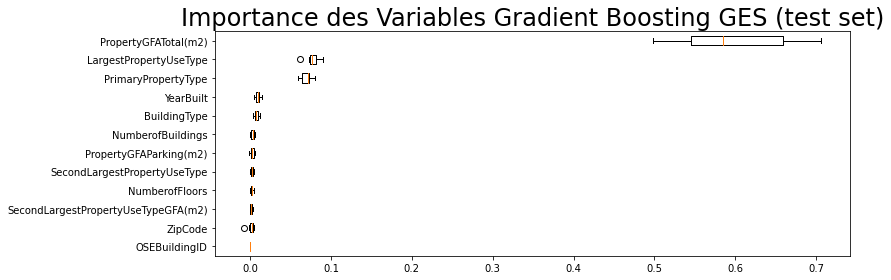

In [34]:
result = permutation_importance(modelGES, X_test_GES, y_test_GES, n_repeats=10,
                                random_state=0, n_jobs = -1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (12,4))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test_GES.columns[sorted_idx])
ax.set_title("Importance des Variables Gradient Boosting GES (test set)", fontsize = 24)
fig.tight_layout()
plt.savefig('Results' + '/' + 'Images' + '/' + 'Importance des Variables Gradient Boosting GES.png',bbox_inches='tight',pad_inches = 1, dpi= 120)
plt.show()

On va garder les trois variables les plus importantes et voir à quel point nous gagnons du temps et perdons en précision.

In [35]:
# Selection des variables
X_train_selected_GES = X_train_GES[['PropertyGFATotal(m2)', 'PrimaryPropertyType',
                                    'LargestPropertyUseType']]

# Test avec les nouvelles variables
categorical_columnsSelectedGES = ['PrimaryPropertyType', 'LargestPropertyUseType']
numerical_columnsSelectedGES = ['PropertyGFATotal(m2)']

preprocessingSelectedGES = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columnsSelectedGES),
     ('num', numerical_pipe, numerical_columnsSelectedGES)])
modelSelectedGES = Pipeline([
    ('preprocess', preprocessingSelectedGES),
    ('regressor', methodGB)
])


# Construction du modele
start_time = timeit.default_timer()
modelSelectedGES.fit(X_train_selected_GES, y_train_GES)

# Etude de performance sans optimisations

pred = modelSelectedGES.predict(X_test_GES[list(X_train_selected_GES.columns)])
elapsed = timeit.default_timer() - start_time

selectedTrainAccuracy =  modelSelectedGES.score(X_train_selected_GES, y_train_GES)
selectedTestAccuracy = modelSelectedGES.score(X_test_GES[list(X_train_selected_GES.columns)], y_test_GES)
selectedrmse = np.sqrt(mean_squared_error(y_test_GES, modelSelectedGES.predict(X_test_GES[list(X_train_selected_GES.columns)])))
selectedTime = elapsed

print("Selected Trained Data train accuracy: %0.3f" % selectedTrainAccuracy)
print("Selected Trained Data test accuracy: %0.3f" % selectedTestAccuracy)
print("The root mean squared error (RMSE) on selected test set: {:.3f}".format(selectedrmse))
print("Elapsed Time Selected {:.2f}s".format(selectedTime))

Selected Trained Data train accuracy: 0.603
Selected Trained Data test accuracy: 0.441
The root mean squared error (RMSE) on selected test set: 1.122
Elapsed Time Selected 0.13s


### Choix des hyperparamètres ###

On va maintenant établir les meilleurs hyperparamètres à choisir grâce à une validation croisée pour chercher à optimiser notre modèle.

Dans un premier temps, on établit les paramètres sur lesquels tester la méthode.

In [36]:
# Nombre d'arbres dans la forêt
n_estimators = [10, 30, 40, 50, 100 ,200]

# Taille maximum des arbres
max_depth = [None, 10, 20, 30, 40, 50]

# Nombre minimum d'échantillon requis pour créer un embranchement
min_samples_split = [2, 6, 12, 18, 24]

# Nombre minimum d'échantillon à chaque feuille
min_samples_leaf = [1, 2, 6, 12 , 18]

# Dictionnaire pour l'evaluation des parametres
grid_parameters = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

Recherche à proprement parler des hyperparamètres

In [37]:
# Preparation du test des hyperparametres
method_random = RandomizedSearchCV(estimator = methodGB,
                                  param_distributions = grid_parameters, n_iter = 600,
                                  cv = 5, verbose = 2, random_state=0, n_jobs = -1)
model_randomGES = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', method_random)
])

# Optimisation des hyperparametres
model_randomGES.fit(X_train_GES, y_train_GES)


print('\n\nLes meilleurs hyperparametres trouves sont : {} \navec un score de {:.2f}'.format(method_random.best_params_, method_random.best_score_))

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 377 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1025 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1470 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1997 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 2604 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 13.0min finished




Les meilleurs hyperparametres trouves sont : {'n_estimators': 100, 'min_samples_split': 24, 'min_samples_leaf': 1, 'max_depth': 10} 
avec un score de 0.49


On fait maintenant un nouveau test avec les hyperparamètres optimisés

In [38]:
optimizedMethod = GradientBoostingRegressor(n_estimators = method_random.best_params_['n_estimators'], 
                                   min_samples_split = method_random.best_params_['min_samples_split'], 
                                   min_samples_leaf = method_random.best_params_['min_samples_leaf'], 
                                   max_depth = method_random.best_params_['max_depth'], 
                                   max_features = None, random_state=0)

optimizedModelGES = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', optimizedMethod)
])

# Construction du modele
start_time = timeit.default_timer()
optimizedModelGES.fit(X_train_GES, y_train_GES)

# Etude de performance avec optimisations

pred = optimizedModelGES.predict(X_test_GES)
elapsed = timeit.default_timer() - start_time

optimizedTrainAccuracy =  optimizedModelGES.score(X_train_GES, y_train_GES)
optimizedTestAccuracy = optimizedModelGES.score(X_test_GES, y_test_GES)
optimizedrmse = np.sqrt(mean_squared_error(y_test_GES, optimizedModelGES.predict(X_test_GES)))
optimizedTime = elapsed

print("Optimized Trained Data train accuracy: %0.3f\n" % (optimizedTrainAccuracy))
print("Optimized Trained Data test accuracy: %0.3f\n" % (optimizedTestAccuracy))
print("Optimized Trained Data test MSE: %0.3f\n" % (optimizedrmse))
print("Optimized Elapsed Time {:.2f}s\n".format(optimizedTime))

Optimized Trained Data train accuracy: 0.881

Optimized Trained Data test accuracy: 0.445

Optimized Trained Data test MSE: 1.118

Optimized Elapsed Time 0.59s



### Tableau Récapitulatif ###

On prend maintenant tous les résultats pour pouvoir les comparer facilement et choisir la meilleure méthode pour ce modèle.

In [39]:
resultatsGES_df = pd.DataFrame()

resultatsGES_df['Trained Data'] = ['Vanilla','Avec ENERGYSTARScore','Moins de Variables','Hyperparametres Optimisés']
resultatsGES_df['Train Precision'] = [baseTrainAccuracy, ESSTrainAccuracy, selectedTrainAccuracy, optimizedTrainAccuracy]
resultatsGES_df['Test Precision'] = [baseTestAccuracy, ESSTestAccuracy, selectedTestAccuracy, optimizedTestAccuracy]
resultatsGES_df['RMSE'] = [basermse, ESSrmse, selectedrmse, optimizedrmse]
resultatsGES_df['Time'] = [baseTime, ESSTime, selectedTime, optimizedTime]
resultatsGES_df

,Trained Data,Train Precision,Test Precision,RMSE,Time
0,Vanilla,0.653075,0.440656,1.122232,0.258394
1,Avec ENERGYSTARScore,0.680182,0.475491,1.086724,0.287884
2,Moins de Variables,0.603102,0.440606,1.122281,0.130708
3,Hyperparametres Optimisés,0.881054,0.445177,1.117687,0.592065


### Graphique Correspondant ###

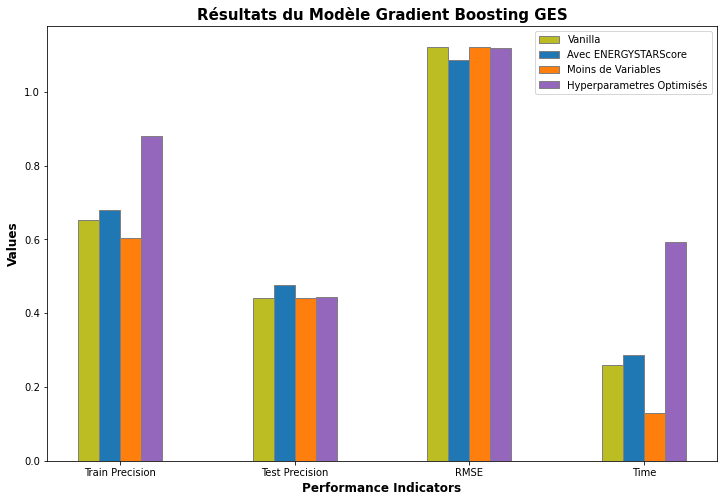

In [40]:
# set width of bar
barWidth = 0.12
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(4)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, list(resultatsGES_df.iloc[0,1:5]), color ='tab:olive', width = barWidth,
        edgecolor ='grey', label ='Vanilla')
plt.bar(br2, list(resultatsGES_df.iloc[1,1:5]), color ='tab:blue', width = barWidth,
        edgecolor ='grey', label ='Avec ENERGYSTARScore')
plt.bar(br3, list(resultatsGES_df.iloc[2,1:5]), color ='tab:orange', width = barWidth,
        edgecolor ='grey', label ='Moins de Variables')
plt.bar(br4, list(resultatsGES_df.iloc[3,1:5]), color ='tab:purple', width = barWidth,
        edgecolor ='grey', label ='Hyperparametres Optimisés')

# Adding Xticks
plt.xlabel('Performance Indicators', fontweight ='bold', fontsize = 12)
plt.ylabel('Values', fontweight ='bold', fontsize = 12)
plt.xticks([r + 1.5 * barWidth for r in range(4)],
        ['Train Precision', 'Test Precision', 'RMSE', 'Time'])
plt.title('Résultats du Modèle Gradient Boosting GES', fontweight ='bold', fontsize = 15)
plt.legend()
plt.savefig('Results' + '/' + 'Images' + '/' + 'Résultats du Modèle Gradient Boosting GES.png',bbox_inches='tight',pad_inches = 1, dpi= 120)
plt.show()

D'après les résultats, nous pouvons en déduire que la méthode la plus adaptée et d'utiliser l'ENERGYSTARScore.

## Et maintenant, l'Energie ##

In [41]:
modelEnergy = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', methodGB)
])

modelESSEnergy = Pipeline([
    ('preprocess', preprocessingESS),
    ('regressor', methodGB)
])

### Premier tets avec l'ENERGYSTARScore ###

In [42]:
# Construction du modele
start_time = timeit.default_timer()
modelESSEnergy.fit(X_ESS_train_energy, y_ESS_train_energy)

# Etude de performance sans optimisations

pred = modelESSEnergy.predict(X_ESS_test_energy)
elapsed = timeit.default_timer() - start_time

ESSTrainAccuracy =  modelESSEnergy.score(X_ESS_train_energy, y_ESS_train_energy)
ESSTestAccuracy = modelESSEnergy.score(X_ESS_test_energy, y_ESS_test_energy)
ESSrmse = np.sqrt(mean_squared_error(y_ESS_test_energy, modelESSEnergy.predict(X_ESS_test_energy)))
ESSTime = elapsed

print("Trained Data ESS train accuracy: %0.3f" % ESSTrainAccuracy)
print("Trained Data ESS test accuracy: %0.3f" % ESSTestAccuracy)
print("The root mean squared error (RMSE) on ESS test set: {:.3f}".format(ESSrmse))
print("Elapsed Time ESS {:.2f}s\n\n".format(ESSTime))

Trained Data ESS train accuracy: 0.825
Trained Data ESS test accuracy: 0.715
The root mean squared error (RMSE) on ESS test set: 0.673
Elapsed Time ESS 0.27s




### Deuxième test sans l'ENERGYSTARScore ###

In [43]:
# Construction du modele
start_time = timeit.default_timer()
modelEnergy.fit(X_train_energy, y_train_energy)

# Etude de performance sans optimisations

pred = modelEnergy.predict(X_test_energy)
elapsed = timeit.default_timer() - start_time

baseTrainAccuracy =  modelEnergy.score(X_train_energy, y_train_energy)
baseTestAccuracy = modelEnergy.score(X_test_energy, y_test_energy)
basermse = np.sqrt(mean_squared_error(y_test_energy, modelEnergy.predict(X_test_energy)))
baseTime = elapsed

print("Trained Data Vanilla train accuracy: %0.3f" % baseTrainAccuracy)
print("Trained Data Vanilla test accuracy: %0.3f" % baseTestAccuracy)
print("The root mean squared error (RMSE) on Vanilla test set: {:.3f}".format(basermse))
print("Elapsed Time Vanilla {:.2f}s".format(baseTime))

Trained Data Vanilla train accuracy: 0.781
Trained Data Vanilla test accuracy: 0.655
The root mean squared error (RMSE) on Vanilla test set: 0.741
Elapsed Time Vanilla 0.25s


### Etude de l'importance des variables dans la décision du modèle ###

En connaissant l'importance portée à chaque variable, on peut définir celles qui sont le plus importante pour le modèle et donc restreindre le nombre de variables pour gagner du temps de calcul.

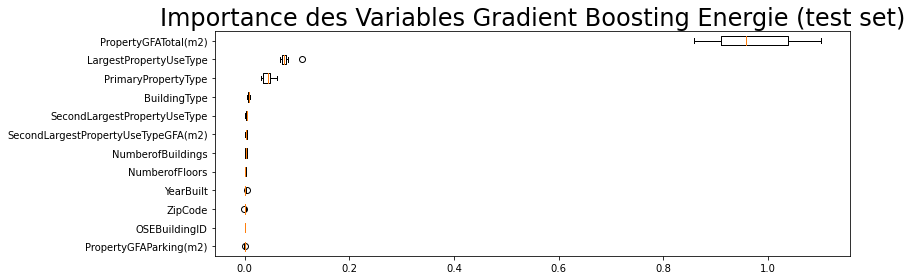

In [44]:
# Etude de l'interet des variables dans la decision du modele

result = permutation_importance(modelEnergy, X_test_energy, y_test_energy, n_repeats=10,
                                random_state=0, n_jobs = -1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (12,4))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test_energy.columns[sorted_idx])
ax.set_title("Importance des Variables Gradient Boosting Energie (test set)", fontsize = 24)
fig.tight_layout()
plt.savefig('Results' + '/' + 'Images' + '/' + 'Importance des Variables Gradient Boosting Energie.png',bbox_inches='tight',pad_inches = 1, dpi= 120)
plt.show()

On va garder les trois variables les plus importantes et voir à quel point nous gagnons du temps et perdons en précision.

In [45]:
# Selection des 4 meilleures variables
X_train_selectedEnergy = X_train_energy[['PropertyGFATotal(m2)','LargestPropertyUseType',
                                         'PrimaryPropertyType']]

# Test avec les nouvelles variables

categorical_columnsSelectedEnergy = ['PrimaryPropertyType', 'LargestPropertyUseType']
numerical_columnsSelectedEnergy = ['PropertyGFATotal(m2)']

preprocessingSelectedEnergy = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columnsSelectedEnergy),
     ('num', numerical_pipe, numerical_columnsSelectedEnergy)])
modelSelectedEnergy = Pipeline([
    ('preprocess', preprocessingSelectedEnergy),
    ('regressor', methodGB)
])


# Construction du modele
start_time = timeit.default_timer()
modelSelectedEnergy.fit(X_train_selectedEnergy, y_train_energy)

# Etude de performance sans optimisations

pred = modelSelectedEnergy.predict(X_test_energy[list(X_train_selectedEnergy.columns)])
elapsed = timeit.default_timer() - start_time

selectedTrainAccuracy =  modelSelectedEnergy.score(X_train_selectedEnergy, y_train_energy)
selectedTestAccuracy = modelSelectedEnergy.score(X_test_energy[list(X_train_selectedEnergy.columns)], y_test_energy)
selectedrmse = np.sqrt(mean_squared_error(y_test_energy, modelSelectedEnergy.predict(X_test_energy[list(X_train_selectedEnergy.columns)])))
selectedTime = elapsed

print("Selected Trained Data train accuracy: %0.3f" % selectedTrainAccuracy)
print("Selected Trained Data test accuracy: %0.3f" % selectedTestAccuracy)
print("The root mean squared error (RMSE) on selected test set: {:.3f}".format(selectedrmse))
print("Elapsed Time Selected {:.2f}s".format(selectedTime))

Selected Trained Data train accuracy: 0.759
Selected Trained Data test accuracy: 0.657
The root mean squared error (RMSE) on selected test set: 0.739
Elapsed Time Selected 0.13s


### Choix des hyperparamètres ###

On va maintenant établir les meilleurs hyperparamètres à choisir grâce à une validation croisée pour chercher à optimiser notre modèle.

Dans un premier temps, on établit les paramètres sur lesquels testes la méthode.

In [46]:
# Nombre d'arbres dans la forêt
n_estimators = [10, 30, 40, 50, 100 ,200]

# Taille maximum des arbres
max_depth = [None, 10, 20, 30, 40, 50]

# Nombre minimum d'échantillon requis pour créer un embranchement
min_samples_split = [2, 6, 12, 18, 24]

# Nombre minimum d'échantillon à chaque feuille
min_samples_leaf = [1, 2, 6, 12 , 18]

# Dictionnaire pour l'evaluation des parametres
grid_parameters = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

Recherche à proprement parler des hyperparamètres.

In [47]:
# Preparation du test des hyperparametres
method_random = RandomizedSearchCV(estimator = methodGB,
                                  param_distributions = grid_parameters, n_iter = 600,
                                  cv = 5, verbose = 2, random_state=0, n_jobs = -1)
model_randomEnergy = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', method_random)
])

# Optimisation des hyperparametres
model_randomEnergy.fit(X_train_energy, y_train_energy)


print('\n\nLes meilleurs hyperparametres trouves sont : {} \navec un score de {:.2f}'.format(method_random.best_params_, method_random.best_score_))

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 14.4min finished




Les meilleurs hyperparametres trouves sont : {'n_estimators': 200, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_depth': 10} 
avec un score de 0.68


On fait maintenant un nouveau test avec les hyperparamètres optimisés.

In [48]:
optimizedMethod = GradientBoostingRegressor(n_estimators = method_random.best_params_['n_estimators'], 
                                   min_samples_split = method_random.best_params_['min_samples_split'], 
                                   min_samples_leaf = method_random.best_params_['min_samples_leaf'], 
                                   max_depth = method_random.best_params_['max_depth'], 
                                   max_features = None, random_state=0)

optimizedModelEnergy = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', optimizedMethod)
])

# Construction du modele
start_time = timeit.default_timer()
optimizedModelEnergy.fit(X_train_energy, y_train_energy)

# Etude de performance avec optimisations

pred = optimizedModelEnergy.predict(X_test_energy)
elapsed = timeit.default_timer() - start_time

optimizedTrainAccuracy = optimizedModelEnergy.score(X_train_energy, y_train_energy)
optimizedTestAccuracy = optimizedModelEnergy.score(X_test_energy, y_test_energy)
optimizedrmse = np.sqrt(mean_squared_error(y_test_energy, optimizedModelEnergy.predict(X_test_energy)))
optimizedTime = elapsed

print("Optimized Data Trained train accuracy: %0.3f\n" % (optimizedTrainAccuracy))
print("Optimized Data Trained test accuracy: %0.3f\n" % (optimizedTestAccuracy))
print("Optimized Data Trained test RMSE: %0.3f\n" % (optimizedrmse))
print("Optimized Elapsed time {:.2f}s\n".format(optimizedTime))

Optimized Data Trained train accuracy: 0.969

Optimized Data Trained test accuracy: 0.642

Optimized Data Trained test RMSE: 0.754

Optimized Elapsed time 1.09s



On prend maintenant tous les résultats pour pouvoir les comparer facilement et choisir la meilleure méthode pour ce modèle.

In [49]:
resultatsEnergy_df = pd.DataFrame()

resultatsEnergy_df['Trained Data'] = ['Vanilla','Avec ENERGYSTARScore','Moins de Variables','Hyperparametres Optimisés']
resultatsEnergy_df['Train Precision'] = [baseTrainAccuracy, ESSTrainAccuracy, selectedTrainAccuracy, optimizedTrainAccuracy]
resultatsEnergy_df['Test Precision'] = [baseTestAccuracy, ESSTestAccuracy, selectedTestAccuracy, optimizedTestAccuracy]
resultatsEnergy_df['RMSE'] = [basermse, ESSrmse, selectedrmse, optimizedrmse]
resultatsEnergy_df['Time'] = [baseTime, ESSTime, selectedTime, optimizedTime]
resultatsEnergy_df

,Trained Data,Train Precision,Test Precision,RMSE,Time
0,Vanilla,0.780839,0.654786,0.740803,0.249350
1,Avec ENERGYSTARScore,0.825197,0.715071,0.673019,0.272160
2,Moins de Variables,0.759459,0.656561,0.738897,0.127435
3,Hyperparametres Optimisés,0.969210,0.642245,0.754139,1.087502


### Graphique Correspondant ###

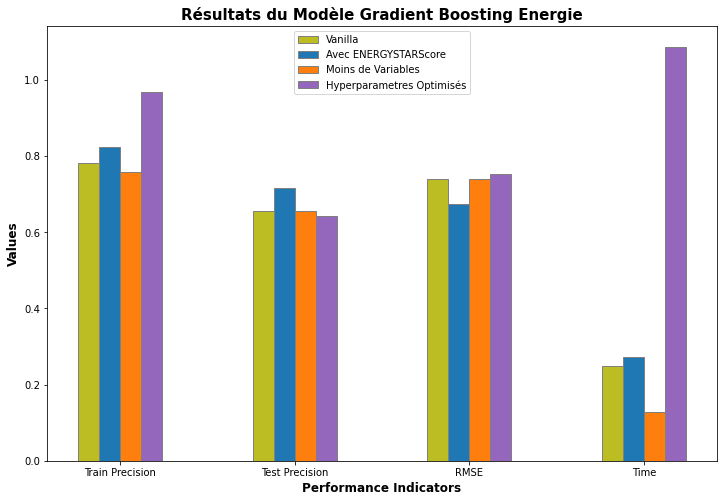

In [50]:
# set width of bar
barWidth = 0.12
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(4)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, list(resultatsEnergy_df.iloc[0,1:5]), color ='tab:olive', width = barWidth,
        edgecolor ='grey', label ='Vanilla')
plt.bar(br2, list(resultatsEnergy_df.iloc[1,1:5]), color ='tab:blue', width = barWidth,
        edgecolor ='grey', label ='Avec ENERGYSTARScore')
plt.bar(br3, list(resultatsEnergy_df.iloc[2,1:5]), color ='tab:orange', width = barWidth,
        edgecolor ='grey', label ='Moins de Variables')
plt.bar(br4, list(resultatsEnergy_df.iloc[3,1:5]), color ='tab:purple', width = barWidth,
        edgecolor ='grey', label ='Hyperparametres Optimisés')

# Adding Xticks
plt.xlabel('Performance Indicators', fontweight ='bold', fontsize = 12)
plt.ylabel('Values', fontweight ='bold', fontsize = 12)
plt.xticks([r + 1.5 * barWidth for r in range(4)],
        ['Train Precision', 'Test Precision', 'RMSE', 'Time'])
plt.title('Résultats du Modèle Gradient Boosting Energie', fontweight ='bold', fontsize = 15)
plt.legend()
plt.savefig('Results' + '/' + 'Images' + '/' + 'Résultats du Modèle Gradient Boosting Energie.png',bbox_inches='tight',pad_inches = 1, dpi= 120)
plt.show()

On fait maintenant un tableau global pour le Gradient Boosting.

In [51]:
resultatsGES_df.columns = pd.MultiIndex.from_product([['Gradient Boosting GES'], resultatsGES_df.columns])
resultatsEnergy_df.columns = pd.MultiIndex.from_product([['Gradient Boosting Energie'], resultatsEnergy_df.columns])
resultatsGB_df = pd.concat([resultatsGES_df, resultatsEnergy_df], axis = 1)
resultatsGB_df

Gradient Boosting GES                                           \
                Trained Data Train Precision Test Precision      RMSE   
0                    Vanilla        0.653075       0.440656  1.122232   
1       Avec ENERGYSTARScore        0.680182       0.475491  1.086724   
2         Moins de Variables        0.603102       0.440606  1.122281   
3  Hyperparametres Optimisés        0.881054       0.445177  1.117687   

             Gradient Boosting Energie                                 \
       Time               Trained Data Train Precision Test Precision   
0  0.258394                    Vanilla        0.780839       0.654786   
1  0.287884       Avec ENERGYSTARScore        0.825197       0.715071   
2  0.130708         Moins de Variables        0.759459       0.656561   
3  0.592065  Hyperparametres Optimisés        0.969210       0.642245   

                       
       RMSE      Time  
0  0.740803  0.249350  
1  0.673019  0.272160  
2  0.738897  0.127435  
3  0.754139  1.087502

D'après les résultats, nous pouvons en déduire que la méthode la plus adaptée est d'utiliser l'ENERGYSTARScore.

Nous allons donc nous servir des deux méthodes établies pour prévoir nos indicateur avec notre modèle.

### Prediction ###

In [52]:
## Pour le GES ##
start_time = timeit.default_timer()

# Construction du modele
chosenModelGES = Pipeline([
    ('preprocess', preprocessingESS),
    ('regressor', methodGB)
])
chosenModelGES.fit(X_ESS_train_GES, y_ESS_train_GES)

# Predictions
predGES = chosenModelGES.predict(dataToPredict_df.iloc[:,:-2])
elapsed = timeit.default_timer() - start_time

# Stockage des performances
GBGESChosenTrainAccuracy =  chosenModelGES.score(X_ESS_train_GES, y_ESS_train_GES)
GBGESChosenTestAccuracy = chosenModelGES.score(X_ESS_test_GES, y_ESS_test_GES)
GBGESChosenrmse = np.sqrt(mean_squared_error(y_ESS_test_GES, chosenModelGES.predict(X_ESS_test_GES)))
GBGESChosenTime = elapsed

print("Temps écoulé pour le GES {:.2f}s\n".format(GBGESChosenTime))


## Pour l'énergie ##
start_time = timeit.default_timer()

# Construction du modele
chosenModelEnergy = Pipeline([
    ('preprocess', preprocessingESS),
    ('regressor', methodGB)
])
chosenModelEnergy.fit(X_ESS_train_energy, y_ESS_train_energy)

# Predictions Energy
predEnergy = chosenModelEnergy.predict(dataToPredict_df.iloc[:,:-2])
elapsed = timeit.default_timer() - start_time

# Stockage des performances
GBEnergyChosenTrainAccuracy =  chosenModelEnergy.score(X_ESS_train_energy, y_ESS_train_energy)
GBEnergyChosenTestAccuracy = chosenModelEnergy.score(X_ESS_test_energy, y_ESS_test_energy)
GBEnergyChosenrmse = np.sqrt(mean_squared_error(y_ESS_test_energy, chosenModelEnergy.predict(X_ESS_test_energy)))
GBEnergyChosenTime = elapsed

print("Temps écoulé pour l'énergie {:.2f}s\n".format(predTime))

# Impression des résultats
print(predGES,'\n\n', predEnergy)

Temps écoulé pour le GES 0.35s

Temps écoulé pour l'énergie 1.18s

[4.02872799 4.26628324 3.69761205 3.80402204 3.00166791 3.63183086
 3.65916915 3.80402204 4.90140343 4.02872799 4.45118829 2.83582484
 4.02872799 5.22864962] 

 [7.87003981 8.63856093 8.18369027 7.67489836 6.74756255 7.50429445
 7.53093522 7.78049545 8.76798292 7.86126618 8.29070168 7.03692226
 8.01556148 9.26836317]


On implémente enfin les résultats dans notre jeu de données, puis on l'enregistre.

In [53]:
# Implentation des predictions dans le jeu de donnees : 

for i in range(len(predEnergy)):
    dataToPredict_df.loc[i,'SiteEnergyUseWN(GJ)'] = np.exp(predEnergy[i])
    dataToPredict_df.loc[i,'TotalGHGEmissions(MetricTonsCO2e)'] = np.exp(predGES[i])

# Enregistrement
dataToPredict_df.to_csv('Results'+'/'+'06_GradientPredictedIndicatorData.csv', index = False)
dataToPredict_df

,OSEBuildingID,ZipCode,YearBuilt,BuildingType,NumberofBuildings,NumberofFloors,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,PropertyGFATotal(m2),PropertyGFAParking(m2),SecondLargestPropertyUseTypeGFA(m2),ENERGYSTARScore,SiteEnergyUseWN(GJ),TotalGHGEmissions(MetricTonsCO2e)
0,87.0,98146.0,1948.0,SPS-District K-12,1.0,2.0,K-12 School,K-12 School,NaN,8.508468,NaN,NaN,NaN,2617.669801,56.189392
1,757.0,98121.0,1979.0,NonResidential,1.0,7.0,Large Office,Office,Retail Store,9.407845,8.999302,6.915998,93.5,5645.200151,71.256301
2,773.0,98104.0,1924.0,NonResidential,NaN,4.0,Small- and Mid-Sized Office,NaN,NaN,8.677069,NaN,NaN,NaN,3582.049026,40.350833
3,19694.0,98122.0,1925.0,SPS-District K-12,1.0,2.0,K-12 School,K-12 School,NaN,8.151273,NaN,NaN,NaN,2153.604775,44.881337
4,20130.0,98115.0,1910.0,NonResidential,1.0,2.0,Worship Facility,Worship Facility,NaN,7.706731,NaN,NaN,89.5,851.979576,20.119066
5,20324.0,98115.0,2000.0,NonResidential,1.0,2.0,Worship Facility,Worship Facility,NaN,7.977918,NaN,NaN,55.0,1815.823663,37.781927
6,21570.0,98125.0,1950.0,SPS-District K-12,1.0,1.0,K-12 School,K-12 School,NaN,8.058064,NaN,NaN,NaN,1864.848735,38.829068
7,21578.0,98116.0,1949.0,SPS-District K-12,1.0,1.0,K-12 School,K-12 School,NaN,8.250504,NaN,NaN,NaN,2393.460372,44.881337
8,24408.0,98103.0,1953.0,SPS-District K-12,1.0,1.0,K-12 School,K-12 School,NaN,9.239554,NaN,NaN,NaN,6425.199242,134.478379
9,25361.0,98115.0,1961.0,SPS-District K-12,1.0,1.0,K-12 School,K-12 School,NaN,8.306109,NaN,NaN,NaN,2594.803788,56.189392


On fait un grand tableau général.

In [54]:
resultatsRidge_df.columns = pd.MultiIndex.from_product([['Kernel Ridge Regression'], resultatsRidge_df.columns])
resultatsForest_df.columns = pd.MultiIndex.from_product([['Random Forest'], resultatsForest_df.columns])
resultats_df = pd.concat([resultatsRidge_df, resultatsForest_df, resultatsGB_df], axis = 1)
resultats_df

Kernel Ridge Regression                                           \
                Trained Data Train Precision Test Precision      RMSE   
0                    Vanilla        0.924380       0.513767  0.981673   
1       Avec ENERGYSTARScore        0.932660       0.568779  0.927708   
2         Moins de Variables        0.630628       0.571942  0.924087   
3  Hyperparametres Optimisés        0.949026       0.514063  0.981908   

                         Random Forest                                 \
       Time               Trained Data Train Precision Test Precision   
0  0.140868                    Vanilla        0.938365       0.527356   
1  0.134164       Avec ENERGYSTARScore        0.944224       0.572100   
2  0.102385         Moins de Variables        0.927621       0.440726   
3  0.127492  Hyperparametres Optimisés        0.793675       0.516505   

                           Gradient Boosting GES                  \
       RMSE      Time               Trained Data Train Precision   
0  0.971168  1.273797                    Vanilla        0.653075   
1  0.927605  1.343803       Avec ENERGYSTARScore        0.680182   
2  1.057483  0.365810         Moins de Variables        0.603102   
3  0.982177  1.252381  Hyperparametres Optimisés        0.881054   

                                      Gradient Boosting Energie  \
  Test Precision      RMSE      Time               Trained Data   
0       0.440656  1.122232  0.258394                    Vanilla   
1       0.475491  1.086724  0.287884       Avec ENERGYSTARScore   
2       0.440606  1.122281  0.130708         Moins de Variables   
3       0.445177  1.117687  0.592065  Hyperparametres Optimisés   

                                                      
  Train Precision Test Precision      RMSE      Time  
0        0.780839       0.654786  0.740803  0.249350  
1        0.825197       0.715071  0.673019  0.272160  
2        0.759459       0.656561  0.738897  0.127435  
3        0.969210       0.642245  0.754139  1.087502

# Conclusion #

On fait également le test avec un modèle linéaire basique pour voir la différence.

In [55]:
start_time = timeit.default_timer()

# Construction du modele
baselineModel = DummyRegressor(strategy = 'median')
baselineModel.fit(X_train, y_train)

# Predictions
pred = baselineModel.predict(dataToPredict_df.iloc[:,:-2])
elapsed = timeit.default_timer() - start_time
predTime = elapsed

# Stockage des performances
baselineTrainAccuracy =  baselineModel.score(X_train, y_train)
baselineTestAccuracy = baselineModel.score(X_test, y_test)
baselinermse = np.sqrt(mean_squared_error(y_test, baselineModel.predict(X_test)))
baselineTime = elapsed

print("Temps écoulé {:.2f}s".format(predTime))
print(pred)

Temps écoulé 0.00s
[[7.96657331 3.89340046]
 [7.96657331 3.89340046]
 [7.96657331 3.89340046]
 [7.96657331 3.89340046]
 [7.96657331 3.89340046]
 [7.96657331 3.89340046]
 [7.96657331 3.89340046]
 [7.96657331 3.89340046]
 [7.96657331 3.89340046]
 [7.96657331 3.89340046]
 [7.96657331 3.89340046]
 [7.96657331 3.89340046]
 [7.96657331 3.89340046]
 [7.96657331 3.89340046]]


On fait maintenant un tableau avec les performances des modèles de prédiction pour chaque type de modèle

In [56]:
# Création de variables nécessaires
GBTrainAccuracy = (GBGESChosenTrainAccuracy + GBEnergyChosenTrainAccuracy) / 2 
GBTestAccuracy = (GBGESChosenTestAccuracy + GBEnergyChosenTestAccuracy) / 2
GBrmse = (GBGESChosenrmse + GBEnergyChosenrmse) / 2
GBTime = GBGESChosenTime + GBEnergyChosenTime

# Création du tableau récapitulatif
performances_df = pd.DataFrame()

performances_df['Model'] = ['Dummy, Median Strategy', 'Kernel Regression Ridge','Random Forest','Gradient Boosting', 'Gradient Boosting GES','Gradient Boosting Energie']
performances_df['Train Precision'] = [baselineTrainAccuracy, RidgeChosenTrainAccuracy, ForestChosenTrainAccuracy, GBTrainAccuracy, GBGESChosenTrainAccuracy, GBEnergyChosenTrainAccuracy]
performances_df['Test Precision'] = [baselineTestAccuracy, RidgeChosenTestAccuracy, ForestChosenTestAccuracy, GBTestAccuracy, GBGESChosenTestAccuracy, GBEnergyChosenTestAccuracy]
performances_df['RMSE'] = [baselinermse, RidgeChosenrmse, ForestChosenrmse, GBrmse, GBGESChosenrmse, GBEnergyChosenrmse]
performances_df['Time'] = [baselineTime, RidgeChosenTime, ForestChosenTime, GBTime, GBGESChosenTime, GBEnergyChosenTime]

performances_df

,Model,Train Precision,Test Precision,RMSE,Time
0,"Dummy, Median Strategy",-0.003830,-0.001997,1.387284,0.002455
1,Kernel Regression Ridge,0.672816,0.616713,0.877937,0.090876
2,Random Forest,0.944224,0.572100,0.927605,1.184421
3,Gradient Boosting,0.752689,0.595281,0.879871,0.622854
4,Gradient Boosting GES,0.680182,0.475491,1.086724,0.349210
5,Gradient Boosting Energie,0.825197,0.715071,0.673019,0.273644


### Graphique Correspondant ###

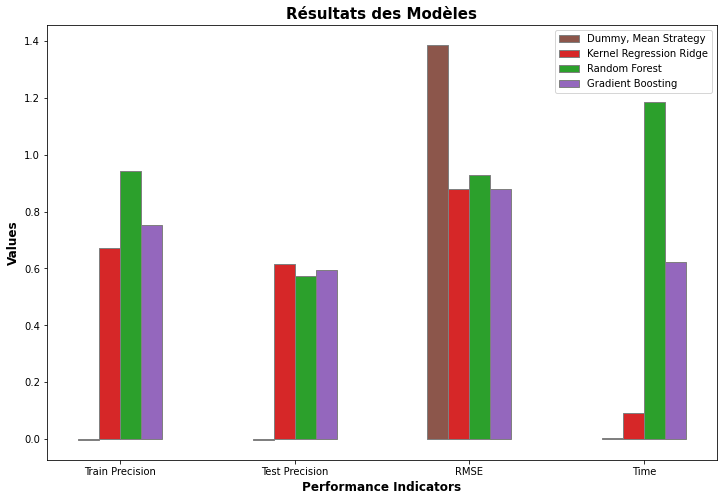

In [57]:
# set width of bar
barWidth = 0.12
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(4)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
#br5 = [x + barWidth for x in br4]
 
# Make the plot
plt.bar(br1, list(performances_df.iloc[0,1:5]), color ='tab:brown', width = barWidth,
        edgecolor ='grey', label ='Dummy, Mean Strategy')
plt.bar(br2, list(performances_df.iloc[1,1:5]), color ='tab:red', width = barWidth,
        edgecolor ='grey', label ='Kernel Regression Ridge')
plt.bar(br3, list(performances_df.iloc[2,1:5]), color ='tab:green', width = barWidth,
        edgecolor ='grey', label ='Random Forest')
plt.bar(br4, list(performances_df.iloc[3,1:5]), color ='tab:purple', width = barWidth,
        edgecolor ='grey', label ='Gradient Boosting')

# Adding Xticks
plt.xlabel('Performance Indicators', fontweight ='bold', fontsize = 12)
plt.ylabel('Values', fontweight ='bold', fontsize = 12)
plt.xticks([r + 1.5 * barWidth for r in range(4)],
        ['Train Precision', 'Test Precision', 'RMSE', 'Time'])
plt.title('Résultats des Modèles', fontweight ='bold', fontsize = 15)
plt.legend()
plt.savefig('Results' + '/' + 'Images' + '/' + 'Résultats des Modèles.png',bbox_inches='tight',pad_inches = 1, dpi= 120)
plt.show()

Au vu des résultats, les meilleurs précision et taux d'erreurs sont obtenus grâce au Gradient Boosting. Les temps sont cependant bien suppérieurs à ceux d'une Kernel Ridge Regression. 

Je choisirai donc le modèle de Gradient Boosting de manière générale comme choix de modélisation. 

L'ENERGYSTARScore amène une quantité de précision non négligeable (10% en plus) et je pense qu'il vaut donc mieux le garder si possible.